<a href="https://colab.research.google.com/github/mostafanadernia/data_mining_projects/blob/main/NaderNia_Final(4).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#<p dir='rtl'>**کتابخانه ها**</p>

In [1]:
from nltk.corpus import sentiwordnet as swn
from nltk.corpus import wordnet as wn
from sklearn.naive_bayes import MultinomialNB
from matplotlib import pyplot

from nltk.stem.wordnet import WordNetLemmatizer
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import spacy
import nltk
import string
from nltk.corpus import stopwords
from nltk import word_tokenize, pos_tag


from sklearn.metrics import confusion_matrix,f1_score, precision_score,recall_score

from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

In [2]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('sentiwordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package sentiwordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/sentiwordnet.zip.


True

#<p dir='rtl'>**فراخوانی داده ها و استفاده از آن ها**

<p dir='rtl'>
در فیلد پایین باید بر اساس مسیر قرار گیری فایل ها تغییرات مسیردهی را اعمال کرد.
</p>

In [3]:
data = pd.read_csv('/content/BTCUSDnews_Nadernia_1.csv',encoding='cp1252')
# Keeping only the neccessary columns
data = data[['Tags','title','articleBody']]
data['text']=data['title']+data['articleBody']

<p dir='rtl'>
در فیلد بالا اگر دستور زیر قرار داده شود مدل به روی نظرات آموزش داده میشود و بار احساسی بر اساس کلمات در نظرات مشخص میشود
</p>

```
data['text']=data['articleBody']
```
<p dir='rtl'>
اگر دستور زیر قرار داده شود بار احساسی عنوان خبر در نظر گرفته میشود 
</p>

```
data['text']=data['title']
```

In [4]:
#import other lists of stopwords
with open('/content/StopWords_GenericLong.txt', 'r') as f:
 x_gl = f.readlines()
with open('/content/StopWords_Names.txt', 'r') as f:
 x_n = f.readlines()
with open('/content/StopWords_DatesandNumbers.txt', 'r') as f:
 x_d = f.readlines()
#import nltk stopwords
stopwords = nltk.corpus.stopwords.words('english')#combine all stopwords
[stopwords.append(x.rstrip()) for x in x_gl]
[stopwords.append(x.rstrip()) for x in x_n]
[stopwords.append(x.rstrip()) for x in x_d]
#change all stopwords into lowercase
stopwords_lower = [s.lower() for s in stopwords]

#<p dir='rtl'>**پیش پردازش داده**

In [5]:
nlp = spacy.load('en', disable=['parser', 'ner'])

In [6]:
def lemmaz(str_input):      #tokenization, remove punctuation, lemmatization
     words=[token.lemma_ for token in nlp(str_input) if not token.is_punct]

 
     # remove symbols, websites, email addresses 
     words = [re.sub(r"[^A-Za-z@]", "", word) for word in words] 
     words = [re.sub(r"\S+com", "", word) for word in words]
     words = [re.sub(r"\S+@\S+", "", word) for word in words] 
     words = [word for word in words if word!=' ']
     words = [word for word in words if len(word)!=0] 
 
     #remove stopwords     
     words=[word.lower() for word in words if word.lower() not in stopwords_lower]
     #combine a list into one string 
       
     string = " ".join(words)    
      
     return string

In [7]:
def Score_preprocessing(sentence):
  words = word_tokenize(sentence)
  tags = pos_tag(words)
  return tags

In [8]:
def penn_to_wn(tag):
    tag=tag[1]
#Convert between the PennTreebank tags to simple Wordnet tags
    if tag.startswith('J'):
        return wn.ADJ
    elif tag.startswith('N'):
        return wn.NOUN
    elif tag.startswith('R'):
        return wn.ADV
    elif tag.startswith('V'):
        return wn.VERB
    return None

def PAENN(Tag):
  list1=[]
  lemmatizer = WordNetLemmatizer()
  i=0
  while i < len(Tag):
    wn_tag=penn_to_wn(Tag[i])
    word = Tag[i][0]
    if wn_tag != None:
      lemma = lemmatizer.lemmatize(word, pos=wn_tag)
      synsets = wn.synsets(lemma, pos=wn_tag)
      if synsets != []:
        list1.append(synsets)
    i+=1
  return list1

In [9]:
def Scores_Syns(synsets):
  result=[]
  i=0
  while i< len(synsets):
    posi=[]
    if synsets != []:
      synset = synsets[i][0]
      swn_synset = swn.senti_synset(synset.name())
      posi.append(swn_synset.pos_score())
      posi.append(swn_synset.neg_score())
      posi.append(swn_synset.pos_score() - swn_synset.neg_score())
    result.append(posi)
    i+=1
  return result

In [10]:
data = data[data.Tags != 0]
data['text']=data['text'].apply(lemmaz)
data['sentiment']=data['text'].apply(Score_preprocessing)
data['Scors']=data['sentiment'].apply(lambda x: PAENN(x))
print("Word is Pos:",data[ data['Tags'] == 1].size)
print("Word is Neg:",data[ data['Tags'] == -1].size)



Word is Pos: 3060
Word is Neg: 1848


In [11]:
data.head(5)

,Tags,title,articleBody,text,sentiment,Scors
0,1,Here’s Why Bitcoin is Likely to See Historic V...,Bitcoin’s price action has been incredibly lac...,bitcoin historic volatility daysbitcoin action...,"[(bitcoin, NN), (historic, JJ), (volatility, N...","[[Synset('historic.s.01'), Synset('historic.s...."
1,-1,"Economist Warns of Warp Speed Dollar Decline, ...","The United States is in turmoil, and the dolla...",economist warn warp decline bitcoin respondthe...,"[(economist, NN), (warn, NN), (warp, VBP), (de...","[[Synset('economist.n.01')], [Synset('falsify...."
2,-1,21 Million BTC: How PayPal Active Users Unders...,An over 300 million active register accounts o...,btc paypal active users underscore bitcoin dig...,"[(btc, NN), (paypal, JJ), (active, JJ), (users...","[[Synset('active.a.01'), Synset('active.s.02')..."
3,-1,Bitcoin Hesitates But This Technical Breakout ...,Bitcoin started a downside correction from the...,bitcoin hesitates technical breakout suggest g...,"[(bitcoin, NN), (hesitates, VBZ), (technical, ...","[[Synset('hesitate.v.01'), Synset('hesitate.v...."
4,1,Here’s Why Bitcoin’s Slow Speed Hasn’t Given R...,"Throughout 2017 and 2018, many altcoin-advocat...",bitcoin slow give rise altcoinsthroughout altc...,"[(bitcoin, RB), (slow, JJ), (give, VBP), (rise...","[[Synset('slow.a.01'), Synset('slow.a.02'), Sy..."


In [12]:
#for idx,row in data.iterrows():
 #   print(idx)
#    row[0] = row[0].replace('rt',' ')
    
max_fatures = 2000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(data['text'].values)
X = tokenizer.texts_to_sequences(data['text'].values)
X = pad_sequences(X)

In [13]:
X

array([[  0,   0,   0, ...,  63,  60,  16],
       [  0,   0,   0, ..., 399, 862,   2],
       [  0,   0,   0, ..., 612, 222, 280],
       ...,
       [  0,   0,   0, ...,   2,   2, 526],
       [  0,   0,   0, ...,  79,   6, 197],
       [  0,   0,   0, ..., 206, 237, 220]], dtype=int32)

In [14]:
Y = pd.get_dummies(data['Tags']).values

In [15]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.33, random_state = 10)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(548, 39) (548, 2)
(270, 39) (270, 2)


#<p dir='rtl'>**مدل سازی با شبکه LSTM**</p>

In [16]:
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 39, 128)           256000    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 39, 128)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 196)               254800    
_________________________________________________________________
dense (Dense)                (None, 2)                 394       
Total params: 511,194
Trainable params: 511,194
Non-trainable params: 0
_________________________________________________________________
None


In [17]:
batch_size = 32
history=model.fit(X_train, Y_train, epochs = 15, batch_size=batch_size, verbose = 2)

Epoch 1/15
18/18 - 6s - loss: 0.6736 - accuracy: 0.6259
Epoch 2/15
18/18 - 4s - loss: 0.6367 - accuracy: 0.6387
Epoch 3/15
18/18 - 4s - loss: 0.5906 - accuracy: 0.6843
Epoch 4/15
18/18 - 4s - loss: 0.4224 - accuracy: 0.8066
Epoch 5/15
18/18 - 4s - loss: 0.4116 - accuracy: 0.8412
Epoch 6/15
18/18 - 4s - loss: 0.2604 - accuracy: 0.9088
Epoch 7/15
18/18 - 4s - loss: 0.1822 - accuracy: 0.9489
Epoch 8/15
18/18 - 4s - loss: 0.1139 - accuracy: 0.9617
Epoch 9/15
18/18 - 4s - loss: 0.0805 - accuracy: 0.9745
Epoch 10/15
18/18 - 4s - loss: 0.0519 - accuracy: 0.9836
Epoch 11/15
18/18 - 4s - loss: 0.0329 - accuracy: 0.9891
Epoch 12/15
18/18 - 4s - loss: 0.0632 - accuracy: 0.9872
Epoch 13/15
18/18 - 4s - loss: 0.0354 - accuracy: 0.9945
Epoch 14/15
18/18 - 4s - loss: 0.0212 - accuracy: 0.9927
Epoch 15/15
18/18 - 4s - loss: 0.0213 - accuracy: 0.9945


In [18]:
print(model.metrics_names)

['loss', 'accuracy']


In [19]:
validation_size = 10

X_validate = X_test[-validation_size:]
Y_validate = Y_test[-validation_size:]
X_test = X_test[:-validation_size]
Y_test = Y_test[:-validation_size]


In [20]:
#X_test.shape
score,acc = model.evaluate(X_validate, Y_validate, verbose = 2, batch_size = batch_size)
print("score Validation On LSTM: %.2f" % (score))
print("acc Validation On LSTM: %.2f" % (acc))

1/1 - 1s - loss: 1.4647 - accuracy: 0.4000
score Validation On LSTM: 1.46
acc Validation On LSTM: 0.40


In [21]:
score,acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size)
print("score Test On LSTM: %.2f" % (score))
print("acc Test On LSTM: %.2f" % (acc))

9/9 - 0s - loss: 1.5862 - accuracy: 0.5731
score Test On LSTM: 1.59
acc Test On LSTM: 0.57


In [22]:
pos_cnt, neg_cnt, pos_correct, neg_correct = 0, 0, 0, 0
for x in range(len(X_validate)):
    
    result = model.predict(X_validate[x].reshape(1,X_test.shape[1]),batch_size=1,verbose = 2)[0]
   
    if np.argmax(result) == np.argmax(Y_validate[x]):
        if np.argmax(Y_validate[x]) == 0:
            neg_correct += 1
        else:
            pos_correct += 1
       
    if np.argmax(Y_validate[x]) == 0:
        neg_cnt += 1
    else:
        pos_cnt += 1



print("pos_acc", pos_correct/pos_cnt*100, "%")
print("neg_acc", neg_correct/neg_cnt*100, "%")

1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
pos_acc 50.0 %
neg_acc 25.0 %


#####<p dir='rtl'>**تست مدل**

In [23]:
# evaluate the model
_, train_acc = model.evaluate(X_train, Y_train, verbose=0)
_, test_acc = model.evaluate(X_test, Y_test, verbose=0)

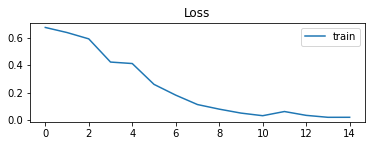

In [24]:
# plot loss during training
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.legend()


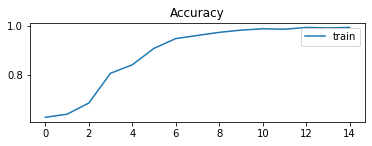

In [25]:
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history.history['accuracy'], label='train')
pyplot.legend()
pyplot.show()


------------Confusion_Matrix-----------

[[ 47  59]
 [ 52 102]]

------------Macro-----------

Precision Score :  0.5541439237091411
Recall Score : 0.5528669443763783

------------Micro-----------

Precision Score :  0.573076923076923
Recall Score : 0.573076923076923

------------Weighted-----------

Precision Score :  0.5688017296712949
Recall Score : 0.573076923076923


------------F1_Score----------

F1_Score : 0.5705315822388993 
------------------------



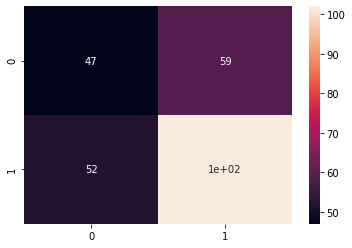

In [26]:

print("\n------------Confusion_Matrix-----------\n")
y_pred = model.predict(X_test)

cf_matrix= confusion_matrix(Y_test.argmax(axis=1),y_pred.argmax(axis=1))
#cf_matrix=confusion_matrix(Y_test,y_pred)
print(cf_matrix)
print("\n------------Macro-----------\n")
print("Precision Score : ",precision_score(Y_test.argmax(axis=1),y_pred.argmax(axis=1),pos_label=1,average='macro'))
print("Recall Score :" , recall_score(Y_test.argmax(axis=1),y_pred.argmax(axis=1), pos_label=1,average='macro') )
print("\n------------Micro-----------\n")
print("Precision Score : ",precision_score(Y_test.argmax(axis=1),y_pred.argmax(axis=1),pos_label=1,average='micro'))
print("Recall Score :" , recall_score(Y_test.argmax(axis=1),y_pred.argmax(axis=1), pos_label=1,average='micro') )
print("\n------------Weighted-----------\n")
print("Precision Score : ",precision_score(Y_test.argmax(axis=1),y_pred.argmax(axis=1),pos_label=1,average='weighted'))
print("Recall Score :" , recall_score(Y_test.argmax(axis=1),y_pred.argmax(axis=1), pos_label=1,average='weighted') )

print('\n\n------------F1_Score----------\n')
print("F1_Score :",f1_score(Y_test.argmax(axis=1),y_pred.argmax(axis=1), pos_label=1,average='weighted'),"\n------------------------\n")

import seaborn as sns
sns.heatmap(cf_matrix, annot=True)

In [27]:
twt = ['Here’s Why Bitcoin is Likely to See Historic.']
#vectorizing the tweet by the pre-fitted tokenizer instance
twt = tokenizer.texts_to_sequences(twt)
#padding the tweet to have exactly the same shape as `embedding_2` input
twt = pad_sequences(twt, maxlen=28, dtype='int32', value=0)
print(twt)
Tags = model.predict(twt,batch_size=1,verbose = 2)[0]
if(np.argmax(Tags) == 0):
    print("negative")
elif (np.argmax(Tags) == 1):
    print("positive")

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   1 715]]
1/1 - 0s
positive


#<p dir='rtl'> مدل سازی با svmخطی

In [28]:
from sklearn.svm import LinearSVC
model1 = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X,data.Tags, data.index, test_size=0.33, random_state=0)
model1.fit(X_train, y_train)
y_pred = model1.predict(X_test)


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


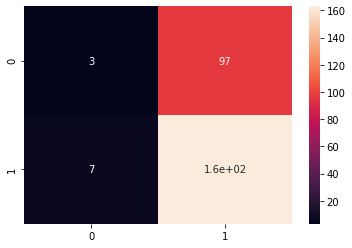

In [29]:
import seaborn as sns
conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True)